In [1]:
import tensorflow as tf
tf.random.set_seed(36)
import os
#https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, MaxPooling2D, GlobalMaxPool2D, Conv2D, Conv2DTranspose,concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import plot_model

## Change the output (decision) to 3-class classifier with softmax activation and categorical cross-entropy loss and reshape the output to vectorized one-hot encoded pixels

In [2]:
#https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
num_class = 3
input_size = (256,256,1)

def conv2d_block(input_tensor, n_filters, kernel_size, batchnorm, activation):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x
  
def get_unet(input_img, n_filters, dropout, batchnorm, kernel_size, activation, depth):
    # Contracting Path
    c=[None]*(depth+3)
    #form 0(=init) to depth(=last decode), also bottom added as depth[depth+1]
    p=[input_img]*(depth+2)
    #Encode
    for current_depth in range(depth):
        current_depth+=1
        c[current_depth]=conv2d_block(p[current_depth-1], n_filters * pow(2,current_depth-1), kernel_size, batchnorm, activation)
        p[current_depth]=MaxPooling2D((2,2))(c[current_depth])
        p[current_depth]=Dropout(dropout)(p[current_depth])
    #Bottom
    c[depth+1]=conv2d_block(p[depth],n_filters* pow(2,depth),kernel_size,batchnorm, activation)
        
    #Decode
    u=[None]*(depth+2)
    d=[c[depth+1]]*(depth+2)
    for current_depth in reversed(range(depth)):
        u[current_depth] = Conv2DTranspose(n_filters * pow(2,current_depth), (kernel_size, kernel_size), strides = (2, 2), padding = 'same')(d[current_depth+1])
        u[current_depth] = concatenate([u[current_depth], c[current_depth+1]])
        u[current_depth] = Dropout(dropout)(u[current_depth])
        d[current_depth] = conv2d_block(u[current_depth], n_filters * pow(2,current_depth), kernel_size, batchnorm, activation)

    #decision
    #outputs = Conv2D(1, (1, 1), activation='sigmoid')(d[0])
    outputs = Conv2D(num_class, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d[0])
    outputs = Conv2D(num_class, 1, activation = 'softmax')(outputs)
    outputs = Reshape([input_size[0]*input_size[1],num_class])(outputs)
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [3]:
im_height=256
im_width=256
input_img = Input((im_height, im_width, 1), name='img')
#mode = get_unet(input_img, n_filter, dropout, Batchnormalization, convolution window size, activation function, depth)
#standard ->unet(input_img, 16, 0.05,True,3,'relu', 4)
model = get_unet(input_img, 16, 0.05, True,3, 'relu',5)
model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

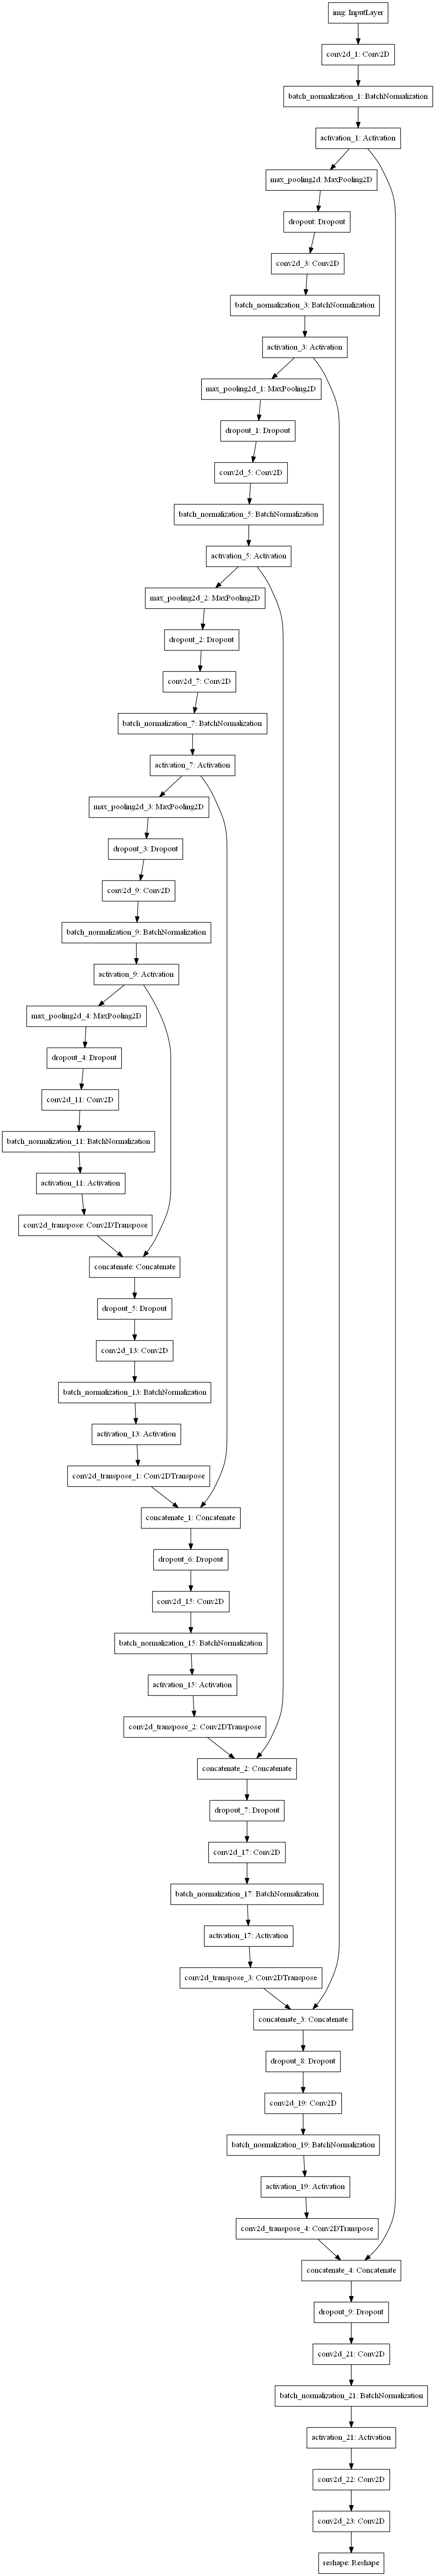

In [4]:
plot_model(model, to_file='diagrams/model_geo.png')

In [5]:
os.mkdir('models/U_net_v02_geo_sparse')
model.save('models/U_net_v02_geo_sparse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/U_net_v02_geo_sparse\assets
